# A Cognitive Model or Harmonic Types (Simplified)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Mounted at /content/drive
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 4.7 MB/s eta 0:00:00


In [3]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

# TODO: set the GPU you want to use
gpu_n = 0

torch.set_default_dtype(torch.float64)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Simplified Model**

Chord Types: These are initially unknown and could represent major, minor, diminished, augmented, etc. We will infer these from the data.

### **Generative Process**:

Chord Type Selection (c): Randomly choose a chord type.
Number of Notes (n): Randomly decide the number of notes in the chord.

Pitch Generation: For each note, sample its pitch from the chosen chord type's distribution.

### **Inference**:

Observed Variables: Number of notes (n) and pitches (p).
Unobserved Variables: Chord type (c) and chord type profiles (ϕ).


## Step 1: Model
**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

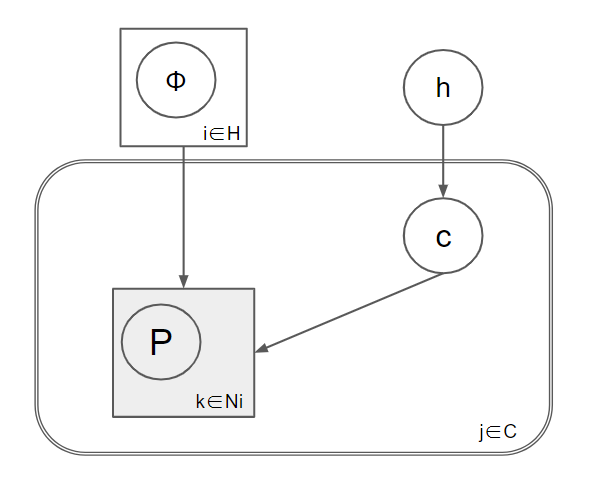



In [7]:
def simplified_chord_model(npcs, nharmonies, data, subsamples=500, **kwargs):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', dist.Dirichlet(0.5 * torch.ones(nharmonies, device=device)))
    # distribution of notes in the harmonies (chord profiles)
    with pyro.plate('harmonies', nharmonies):
        chord_profiles = pyro.sample('chord_profiles', dist.Dirichlet(0.5 * torch.ones(npcs, device=device)))

    # Sampling the data:
    nchords = len(data['c'])
    subs = min(nchords, subsamples) if subsamples is not None else None

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Sample a chord type based on the harmony distribution (to be inferred)
        c = pyro.sample('c', dist.Categorical(p_harmony))

        # number of notes in the chord, not going to use
        # n = int(data['n'])
        # sampling pitches for the chord based on the selected chord type profile
        pitches = pyro.sample('pitches', dist.Multinomial(1, probs=chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    return {"p_harmony": p_harmony, "chord_profiles": chord_profiles, "c": c, "pitches": pitches}

 Step 2: Guide for Inference


In [8]:
def simplified_chord_guide(npcs, nharmonies, data, subsamples=500, **kwargs):
    # no need to guide observed variables like pitches and number of notes
    # for the distribution of the harmonies
    alpha_h = pyro.param('alpha_h', torch.ones(nharmonies, device=device), constraint=constraints.positive)
    pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

    # for the chord profiles
    with pyro.plate('harmonies', nharmonies):
        alpha_phi = pyro.param('alpha_phi', torch.ones(npcs, device=device), constraint=constraints.positive)
        pyro.sample('chord_profiles', dist.Dirichlet(alpha_phi))

    # for the chord types
    nchords = len(data['c'])
    subs = min(nchords, subsamples) if subsamples is not None else None
    with pyro.plate('data', nchords, subsample=subs) as ind:
        probs_c = pyro.param('probs_c', torch.ones(nharmonies, device=device), constraint=constraints.simplex)
        pyro.sample('c', dist.Categorical(probs=probs_c))

## Step 3: Data and Conditioning
**Data Format**


In [9]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [10]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [11]:
def get_init_params(df, nharms, npcs):
    init = dict()

    # initialize params for harmonies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    # initialize params for chord profiles
    init['chord_profiles'] = torch.zeros([nharms, npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df.groupby(['numlabel', 'fifth']):
        init['chord_profiles'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    chord_sizes = df.groupby('chordid').size()
    init['sum_chords'] = torch.tensor(sum(chord_sizes), device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes), device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.



In [12]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

In [13]:
def infer_posteriors(obs, init, nharmonies, npcs,
                     nsteps=5000, subsamples=10000, particles=1,
                     plot_loss=True, save_as=None):
    # Optimize the parameters of the guide
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)  # set every time for independent reproducibility
    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=simplified_chord_guide,
                         optim=pyro.optim.Adam({"lr": 0.01, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.Trace_ELBO(num_particles=particles))

    # Set up histories for the loss and some of the parameters
    losses = np.zeros(nsteps)
    harmony_history = np.zeros((nsteps, nharmonies))
    chord_profile_history = np.zeros((nsteps, nharmonies, npcs))

    # Run the optimization
    for i in tqdm.trange(nsteps):
        # Update parameters and record loss
        losses[i] = svi.step(npcs, nharmonies, obs, subsamples, init=init)

        # Record values of some parameters
        ps = pyro.get_param_store()
        harmony_history[i] = ps.get_param('alpha_h').cpu().detach().numpy()
        chord_profile_history[i] = ps.get_param('alpha_phi').cpu().detach().numpy()

    # Plot the loss
    if plot_loss:
        plt.figure()
        plt.plot(losses)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.title(f"loss ({save_as})")
        plt.show(block=False)
        print("loss variance (last 100 steps):", losses[-100:].var())

    # Extract the parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}
    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, harmony_history, chord_profile_history

## Step 5: Plotting

In [14]:
# histories

def plot_param_history(name, ax, history, ylabel):
    ax.plot(history)
    ax.set_xlabel("iteration")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} ({name})")

def plot_histories(name, harmony_history, chord_profile_history, num_harmonies_to_display=14):
    num_harmonies = harmony_history.shape[1]
    num_profiles = chord_profile_history.shape[1]

    num_harmonies_to_display = min(num_harmonies, num_harmonies_to_display)

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 3]})

    # plot harmony history
    for i in range(num_harmonies_to_display):
        axes[0].plot(harmony_history[:, i], label=f"Harmony {i+1}")
    axes[0].set_title(f"Harmony Parameters History ({name})")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Parameter value")
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # plot chord profile history (average over chord types)
    avg_chord_profile = np.mean(chord_profile_history[:, :num_harmonies_to_display, :], axis=(1, 2))
    axes[1].plot(avg_chord_profile, label="Average Chord Profile")
    axes[1].set_title(f"Avg Chord Profile History ({name})")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Average Parameter value")
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [15]:
# posterior

def plot_posteriors(name, params, nharmonies, npcs):
    # extract harmony and chord profile parameters
    harmony_params = params['alpha_h']
    chord_profile_params = params['alpha_phi']

    harmony_normalized = harmony_params / np.sum(harmony_params)
    chord_profile_normalized = np.array([cp / np.sum(cp) for cp in chord_profile_params])

    num_subplots = nharmonies + 1

    fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 3 * num_subplots))

    axs[0].bar(np.arange(len(harmony_normalized)), harmony_normalized)
    axs[0].set_title(f'Harmony Distribution ({name})')
    axs[0].set_xlabel('Harmony Types')
    axs[0].set_ylabel('Probability')

    # plot chord profile parameters for each harmony
    for i in range(nharmonies):
        axs[i + 1].bar(np.arange(npcs), chord_profile_normalized[i])
        axs[i + 1].set_title(f'Chord Profile for Harmony {i} ({name})')
        axs[i + 1].set_xlabel('Pitches')
        axs[i + 1].set_ylabel('Probability')

    plt.tight_layout()
    plt.show()

# 2. Experiment

**DCML**

In [16]:
# prepare the dataset
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


100%|██████████| 350/350 [03:58<00:00,  1.47it/s]


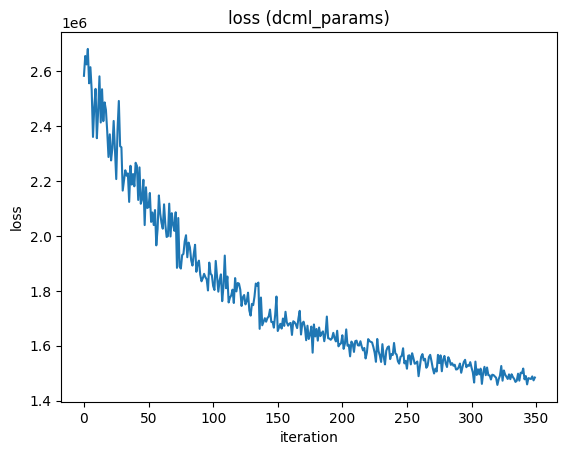

loss variance (last 100 steps): 883220505.8329401


In [17]:
# Run the optimization
dcml_params, dcml_harmony_history, dcml_chord_profile_history = infer_posteriors(obs=dcml_obs, init=dcml_init,
                                                                       nharmonies=len(dcml_chordtypes),
                                                                       npcs=npcs, nsteps=350, subsamples=None,
                                                                       particles=1, save_as="dcml_params")

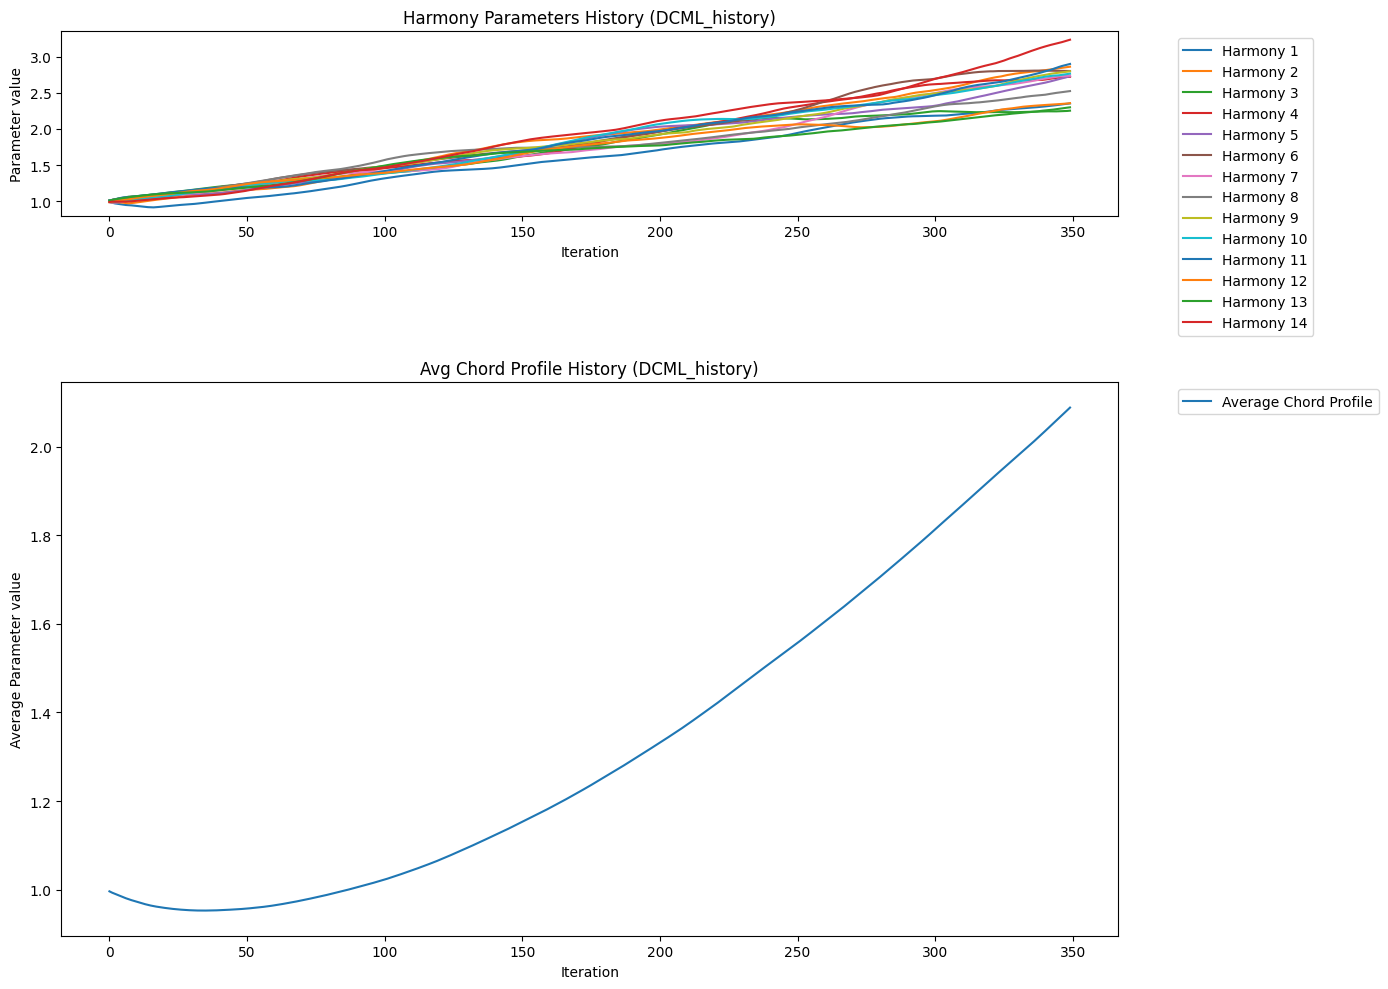

In [18]:
plot_histories("DCML_history", dcml_harmony_history, dcml_chord_profile_history)

**Harmony Parameters History**: shows convergence of harmony parameters over iterations. All harmony parameters seem to converges.

**Average Chord Profile History**: The average chord profile parameter value increases with iterations, which implies that the model is becoming more confident in chord profile predictions as more data is observed.


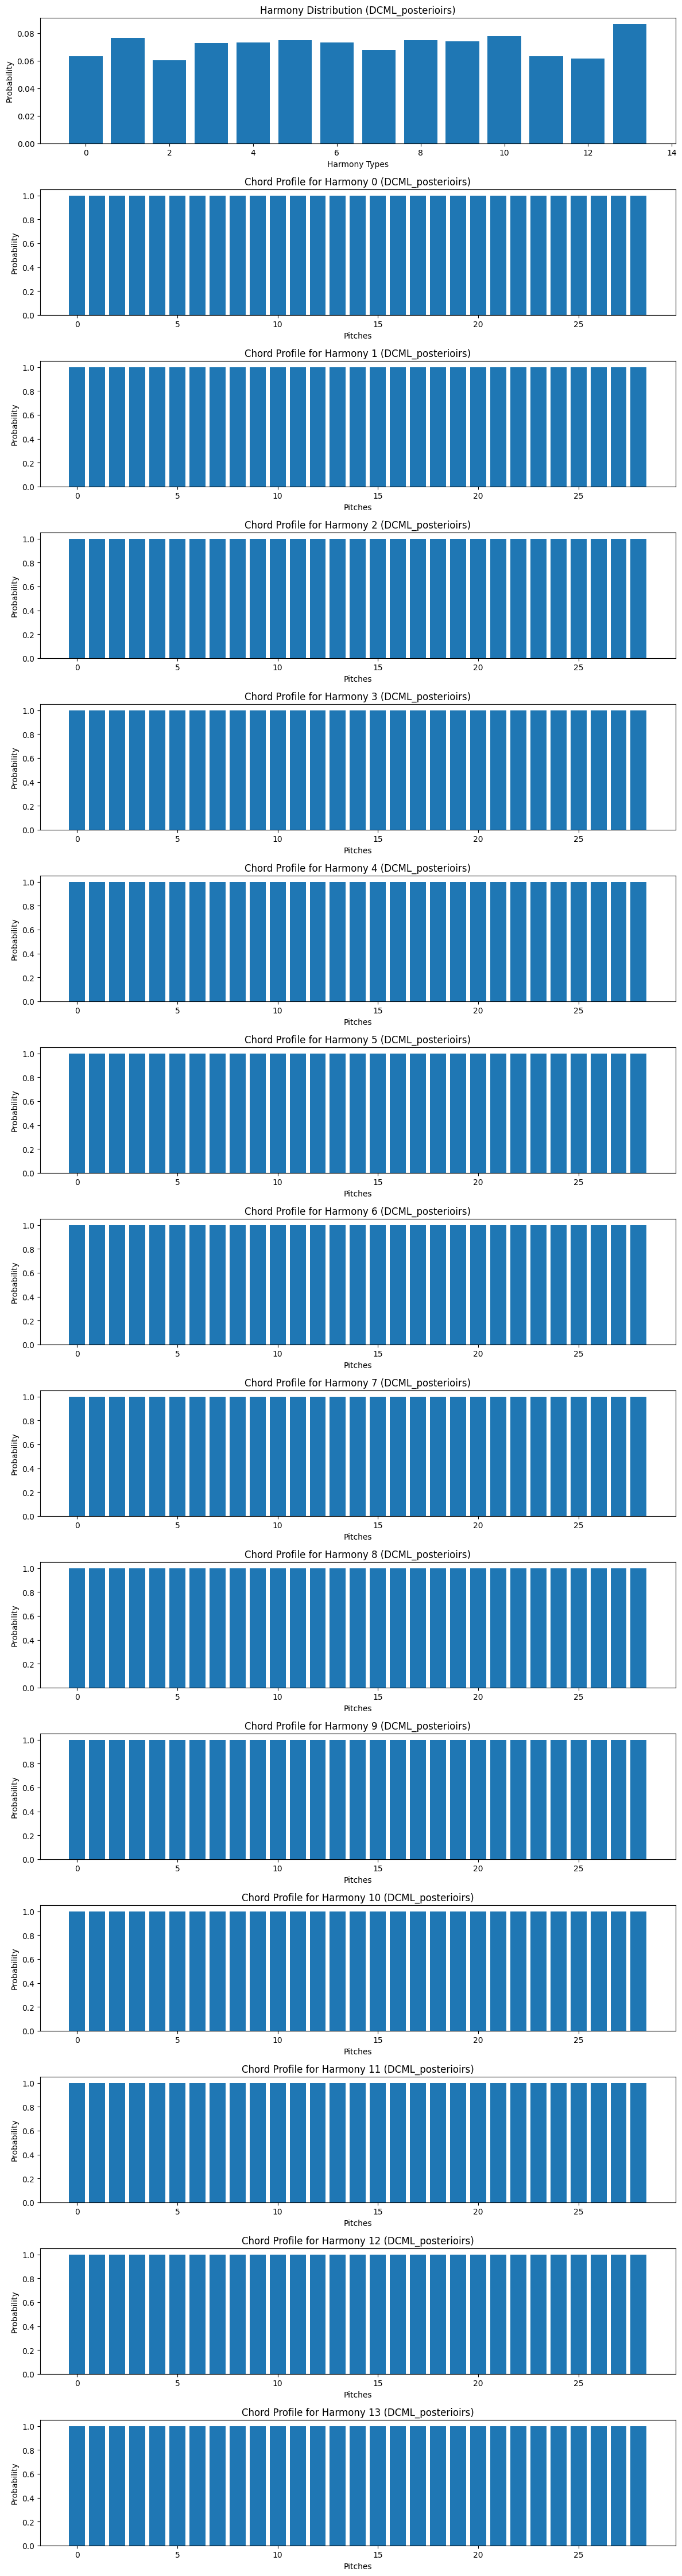

In [19]:
plot_posteriors("DCML_posterioirs", dcml_params, len(dcml_chordtypes), npcs)


**Harmony Distribution and Chord Profiles**: The bar plots of harmony distribution and chord profiles indicate a relatively uniform distribution of harmonies in chord profiles for each harmony.

**EWLD**

In [20]:
ewld_df, ewld_obs, ewld_chordtypes = load_dataset('ewld.tsv')
ewld_init = get_init_params(ewld_df, len(ewld_chordtypes), npcs)
ewld_init['harmonies'].int()

loading dataset...
using precomputed tensor data.
24 chord types
188912 chords


tensor([245989, 163573,  83664,  56140,  21851,  12632,  11145,   6799,   5464,
          4071,   3161,   2870,   2719,   2133,   1922,   1902,   1245,    662,
           576,    482,    379,    249,    133,     22], dtype=torch.int32)